# Setting up the model and the parameters

In [1]:
import righor
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tqdm import tqdm
from collections import Counter
import numpy as np


# load the model
model = righor.vdj.Model.load_model("../models/human_T_beta/model_params.txt",
"../models/human_T_beta/model_marginals.txt",
"../models/human_T_beta/V_gene_CDR3_anchors.csv",
"../models/human_T_beta/J_gene_CDR3_anchors.csv")


# define parameters for the alignment and the inference
align_params = righor.AlignmentParameters()
infer_params = righor.InferenceParameters()

# Default parameters favour accuracy rather than speed
# generally no need to modify them
print(align_params)
print(infer_params)

AlignmentParameters(min_score_v=0, min_score_j=0, max_error_d=100. left_v_cutoff=40)
InferenceParameters(min_likelihood=0, min_ratio_likelihood=0, infer=false. store_best_event=true)


## Evaluating a given sequence

In [2]:
sequence = "GATGCTGAAATCACCCAGAGCCCAAGACACAAGATCACAGAGACAGGAAGGCAGGTGACCTTGGCGTGTCACCAGACTTGGAACCACAACAATATGTTCTGGTATCGACAAGACCTGGGACATGGGCTGAGGCTGATCCATTACTCATATGGTGTTCACGACACTAACAAAGGAGAAGTCTCAGATGGCTACAGTGTCTCTAGATCAAACACAGAGGACCTCCCCCTCACTCTGGAGTCTGCTGCCTCCTCCCAGACATCTGTATATTTCTGCGCCAGCAGTGAGCGGACAGGGGGCCTAGCAATCAGCCCCAGCATTTTGGTGATGGGACTCGACTCTCCATCCTAG"

# first align the sequence
alignment = model.align_sequence(sequence, align_params)

# then evaluate the alignment
result = model.evaluate(alignment, infer_params)

# Clean display of the result
print(result.display(model))

Result:
	Likelihood: 3.24e-13, pgen: 0.00e0
	Most likely event:
	- CDR3 (nucleotides): TGCGCCAGCAGTGAGCGGACAGGGGGCCTAGCAATCAGCCCCAGCATTTT 
	- CDR3 (amino acids):  
	- V name: TRBV10-1*02 
	- J name: TRBJ1-5*01 
	- likelihood ratio: 0.08366745966613477 
 


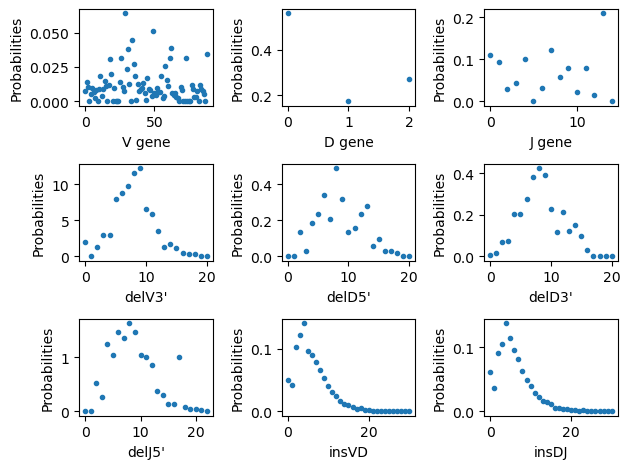

array([1.94021318e+00, 5.67251817e-02, 1.29175147e+00, 2.93673213e+00,
       3.03304651e+00, 7.93925112e+00, 8.80454796e+00, 9.71969439e+00,
       1.16137818e+01, 1.22176280e+01, 6.61989570e+00, 5.95615318e+00,
       3.56701897e+00, 1.32475837e+00, 1.76946331e+00, 1.10985637e+00,
       4.64892714e-01, 2.89894173e-01, 2.99503754e-01, 1.17364929e-02,
       3.34552121e-02])

In [3]:
## Representation of the probabilities of the events for that specific sequence
fig, axes = plt.subplots(3, 3)

for ax in axes.flatten():
    ax.set_ylabel("Probabilities")

# Marginal probabilities of the V genes (for this specific sequence)
pv = result.features.vdj.probas.sum(axis=(1,2))
axes[0, 0].plot(pv, '.')
axes[0, 0].set_xlabel("V gene")

# Marginal probabilities of the D genes
pd = result.features.vdj.probas.sum(axis=(0,2))
axes[0, 1].plot(pd, '.')
axes[0, 1].set_xlabel("D gene")

# Marginal probabilities of the J genes
pj = result.features.vdj.probas.sum(axis=(0,1))
axes[0, 2].plot(pj, '.')
axes[0, 2].set_xlabel("J gene")

# Marginal probabilities of the V deletion 
pdelv = result.features.delv.probas.sum(axis=(1))
axes[1, 0].plot(pdelv, '.')
axes[1, 0].set_xlabel("delV3'")

# Marginal probabilities of the D5 deletion 
pdeld5 = result.features.deld.probas.sum(axis=(1,2))
axes[1, 1].plot(pdeld5, '.')
axes[1, 1].set_xlabel("delD5'")

# Marginal probabilities of the D3 deletion 
pdeld3 = result.features.deld.probas.sum(axis=(0,2))
axes[1, 2].plot(pdeld3, '.')
axes[1, 2].set_xlabel("delD3'")

# Marginal probabilities of the J deletion 
pdelj = result.features.delj.probas.sum(axis=(1))
axes[2, 0].plot(pdelj, '.')
axes[2, 0].set_xlabel("delJ5'")
# Marginal probabilities of the insvd insertions
pinsvd = result.features.insvd.length_distribution
axes[2, 1].plot(pinsvd, '.')
axes[2, 1].set_xlabel("insVD")
# Marginal probabilities of the insdj insertions
pinsdj = result.features.insdj.length_distribution
axes[2, 2].plot(pinsdj, '.')
axes[2, 2].set_xlabel("insDJ")

plt.tight_layout()
plt.show()

# Marginal probabilities of the deletion on V, 3'
result.features.delv.probas.sum(axis=1)

## Generating sequences

In [4]:
seed = 42
# or model.generator() if you don't want a seed
generator = model.generator(seed) 
print(generator.generate(True).full_seq)

GAAGCTGACATCTACCAGACCCCAAGATACCTTGCTATAGGGACAGGAAAGAAGATCACTCTGGAATGTTCTCTAACCATGGGCCATGAGAAAATGTACTGGTATCAACAAGATCCAGGAATGGAACTACACCTCATCCACTATTCCTATGGAGTTAATTCCACAGAGAAGGGAGATCTTTCCTCTGAGTCAACAGTCTCCAGAATAAGGACGGAGCATTTTCCCCTGACCCTGGAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGTGAGGACAGGGACGTCACTGAAGCTTTCTTTGGACAAGGCACCAGACTCTCAGTTGTAG


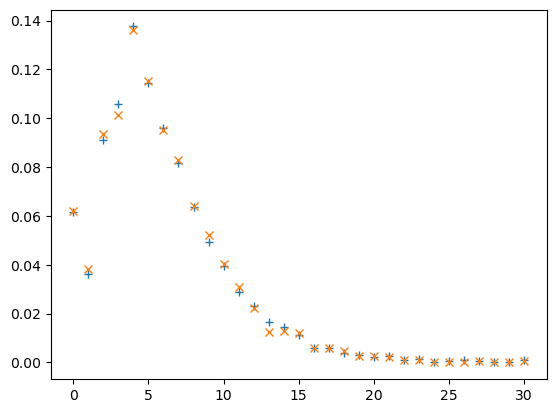

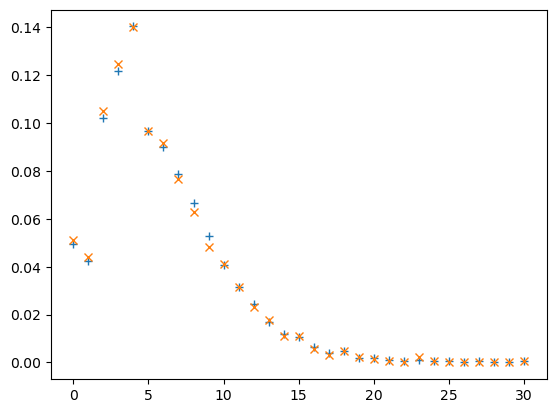

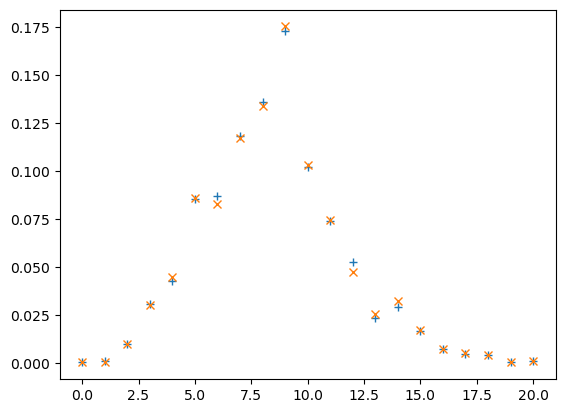

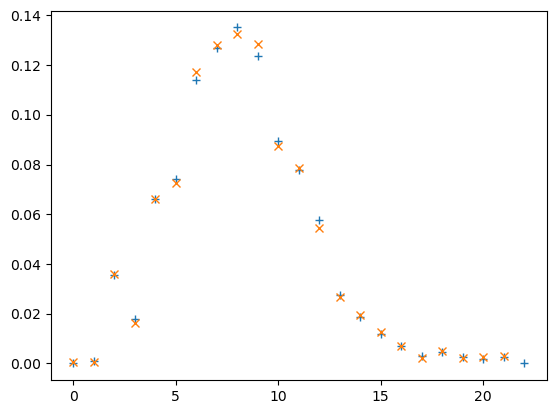

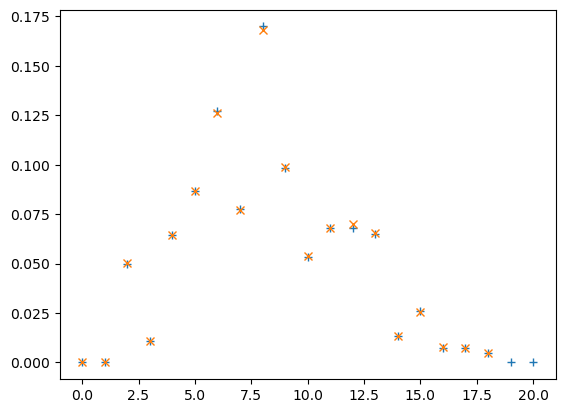

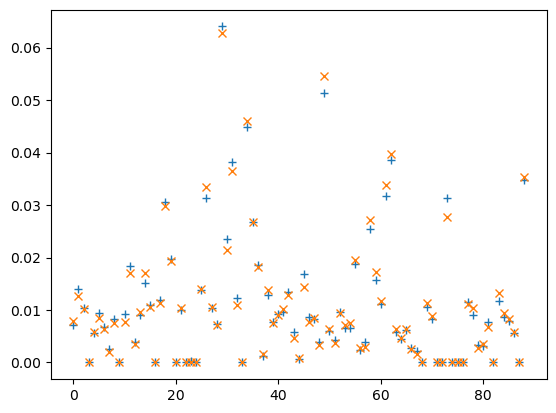

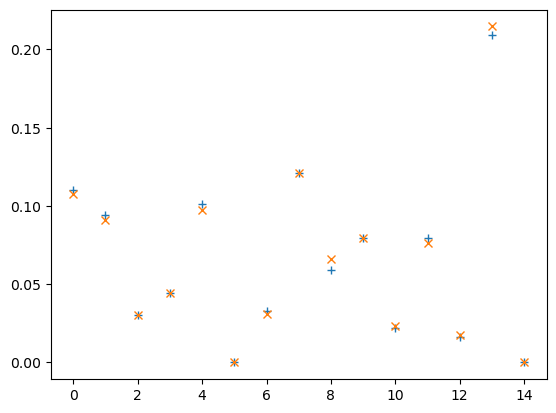

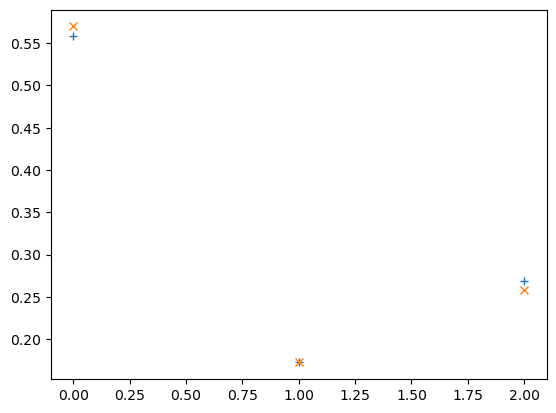

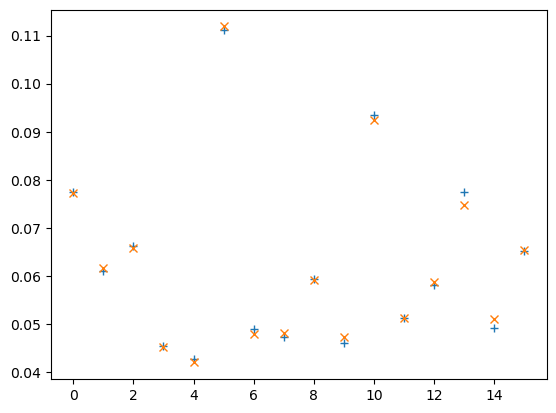

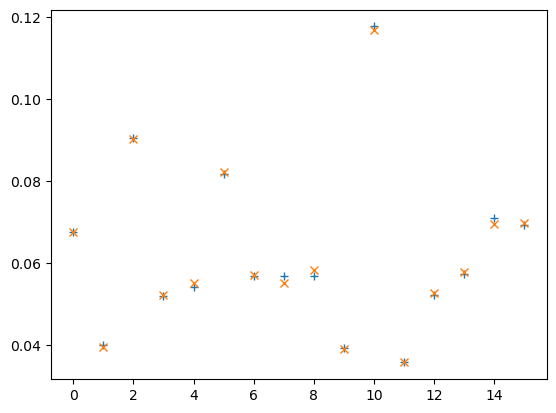

In [5]:
## Sanity check, do the generated values follow the distribution of the models ?

lst = []
for _ in range(10000):
    lst += [len(generator.generate(False).recombination_event.insdj.get_string())]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1)])
result_gen = result_gen / result_gen.sum()
plt.plot(model.p_ins_dj, '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []
for _ in range(10000):
    lst += [len(generator.generate(False).recombination_event.insvd.get_string())]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1) ])
result_gen = result_gen / result_gen.sum()
plt.plot(model.p_ins_vd, '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []
for _ in range(10000):
    lst += [generator.generate(False).recombination_event.delv]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1)])
result_gen = result_gen / result_gen.sum()
plt.plot((model.p_del_v_given_v @ model.p_v)/((model.p_del_v_given_v @ model.p_v)).sum(), '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []
for _ in range(10000):
    lst += [generator.generate(False).recombination_event.delj]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1)])
result_gen = result_gen / result_gen.sum()
plt.plot((model.p_del_j_given_j @ model.p_dj.sum(axis=0))/(model.p_del_j_given_j @ model.p_dj.sum(axis=0)).sum(), '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []
for _ in range(100000):
    lst += [generator.generate(False).recombination_event.deld5]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1)])
result_gen = result_gen / result_gen.sum()
plt.plot((model.p_del_d5_del_d3 @ model.p_dj.sum(axis=1)).sum(axis=(1))/(model.p_del_d5_del_d3 @ model.p_dj.sum(axis=1)).sum(), '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []
for _ in range(10000):
    lst += [generator.generate(False).recombination_event.v_index]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1)])
result_gen = result_gen / result_gen.sum()
plt.plot(model.p_v, '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []
for _ in range(10000):
    lst += [generator.generate(False).recombination_event.j_index]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1)])
result_gen = result_gen / result_gen.sum()
plt.plot(model.p_dj.sum(axis=0), '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []
for _ in range(10000):
    lst += [generator.generate(False).recombination_event.d_index]
dct = Counter(lst)
result_gen = np.array([dct[ii] if ii in dct else 0 for ii in range(0, max(lst)+1)])
result_gen = result_gen / result_gen.sum()
plt.plot(model.p_dj.sum(axis=1), '+')
plt.plot(result_gen, 'x')
plt.show()

lst = []  ### deal with this bug
lst2 = []
for _ in range(10000):
    s = generator.generate(False).recombination_event.insvd.get_string()
    lst += [(a, b) for a, b in zip(s, s[1:])]
    lst2 += [b for b in s[:-1]]
dct = Counter(lst)
dct2 = {a:Counter(lst2)[a]/sum(Counter(lst2).values()) for a in Counter(lst2)}
dct = {a: dct[a]/dct2[a[0]] for a in dct}
dct = {a: dct[a]/sum(dct.values()) for a in dct}

result_gen = result_gen / result_gen.sum()
plt.plot(model.markov_coefficients_vd.flatten()/model.markov_coefficients_vd.sum(), '+')
plt.plot([dct[a] for a in [('A', 'A'),('A', 'C'),('A', 'G'),('A', 'T'),
                           ('C', 'A'),('C', 'C'),('C', 'G'),('C', 'T'),
                           ('G', 'A'),('G', 'C'),('G', 'G'),('G', 'T'),
                           ('T', 'A'),('T', 'C'),('T', 'G'),('T', 'T')]], 'x')
plt.show()

lst = []  ### deal with this bug
lst2 = []
for _ in range(10000):
    s = generator.generate(False).recombination_event.insdj.get_string()
    # reversed direction
    lst += [(b, a) for a, b in zip(s, s[1:])]
    lst2 += [b for b in s[1:]]
dct = Counter(lst)
dct2 = {a:Counter(lst2)[a]/sum(Counter(lst2).values()) for a in Counter(lst2)}
dct = {a: dct[a]/dct2[a[0]] for a in dct}
dct = {a: dct[a]/sum(dct.values()) for a in dct}

result_gen = result_gen / result_gen.sum()
plt.plot(model.markov_coefficients_dj.flatten()/model.markov_coefficients_dj.sum(), '+')
plt.plot([dct[a] for a in [('A', 'A'),('A', 'C'),('A', 'G'),('A', 'T'),
                           ('C', 'A'),('C', 'C'),('C', 'G'),('C', 'T'),
                           ('G', 'A'),('G', 'C'),('G', 'G'),('G', 'T'),
                           ('T', 'A'),('T', 'C'),('T', 'G'),('T', 'T')]], 'x')

plt.show()

## Inferring a model

In [6]:
# create an uniform model with the same V/D/J genes & range for deletions
uniform_model = model.uniform()

In [7]:
# we're going to re-infer the model starting from the uniform_model

seed = 42
print("Generate...")
generator = model.generator(seed)
sequences = [generator.generate(True).full_seq
             for a in tqdm(range(10000))]

print("Align...")
# first align the sequences
alignments = [uniform_model.align_sequence(s, align_params) 
              for s in tqdm(sequences)]




Generate...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 121603.64it/s]


Align...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:00<00:00, 27.77it/s]


In [ ]:
print("Infer...")
models = {}
for rd in range(5):
    print(rd, end=" ")
    models[rd] = uniform_model.copy()
    uniform_model.infer(alignments, infer_params)


NameError: name 'models' is not defined

In [ ]:
from collections import Counter
import numpy as np
lst = []

fig, ax = plt.subplots()
pinsdj = model.p_ins_dj
for ii in range(5):
    pinsdj_inf = models[ii].p_ins_dj
    ax.plot(pinsdj_inf, '.', label = f"round {ii}", alpha=0.2)
ax.plot(pinsdj, '+', label="real")

ax.set_xlabel("insDJ")
plt.legend()
plt.show()

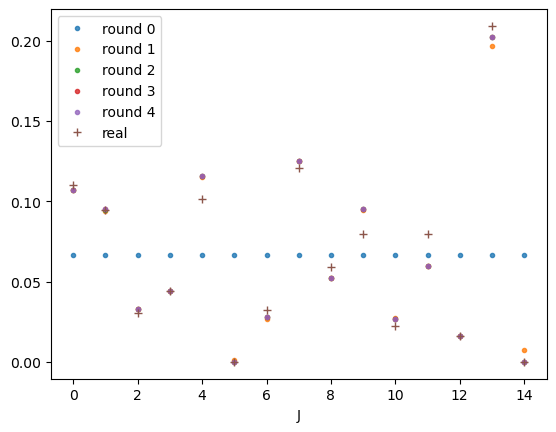

In [23]:
from collections import Counter
import numpy as np
lst = []

fig, ax = plt.subplots()
pj = model.p_vdj.sum(axis=(0,1))
for ii in range(5):
    pj_inf = models[ii].p_vdj.sum(axis=(0,1))
    ax.plot(pj_inf, '.', label = f"round {ii}", alpha=0.8)
ax.plot(pj, '+', label="real")

ax.set_xlabel("J")
plt.legend()
plt.show()

In [12]:
models[1].p_v[32]

1.0

In [13]:
models[1].p_del_v_given_v[:, 32]

array([6.71871807e-01, 2.25406620e-01, 7.08954802e-02, 2.19546126e-02,
       6.81447692e-03, 2.10987010e-03, 6.53526204e-04, 2.02578706e-04,
       6.28239414e-05, 1.94532147e-05, 6.03622810e-06, 1.87486937e-06,
       5.79899843e-07, 1.79752881e-07, 5.55560326e-08, 1.71873986e-08,
       5.31158250e-09, 1.64278396e-09, 5.08412434e-10, 1.57003166e-10,
       4.84564612e-11])

In [31]:
from pympler import asizeof
asizeof.asizeof(alignments)

8856

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 5.8 MB/s eta 0:00:00
